<img src="https://raw.githubusercontent.com/LotusZaheer/Proyecto/master/Banner.jpg" align="center"/>


<h4>Universidad Industrial de Santander</h4>
<h3>Inteligencia Artificial II - J1</h3>
<h3>Profesor Fabio Martínez Carrillo</h3>
<br>
Orlando Alberto Moncada Rodríguez 2170133
<br>
Andrés Felipe Uribe García - 2160793
<br>
Juan Felipe Ortiz Trillos 2170105

Los datos provienen del dataset https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification el cual contiene diferentes pistas de audio ordenadas por genero musical 

In [ ]:
#@title Drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')
Root = "/content/drive/MyDrive"
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
# @title Librerias

import sys
import time
import re
import librosa
import librosa.display
import random
import numpy as np
import pandas as pd
from keras import backend as K
from tqdm import tqdm

from keras.preprocessing import image
import glob
import imageio
import time

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras import layers 
!pip install tensorflow-addons
import tensorflow_addons as tfa

from sklearn import metrics
from sklearn import datasets
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

%matplotlib inline

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#@title Paths
path = '/content/drive/MyDrive/Proyecto/models'
audio_dataset_path='/content/drive/MyDrive/Proyecto/Data/genres_original'
metadata=pd.read_csv('/content/drive/MyDrive/Proyecto/Data/features_30_sec.csv')
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


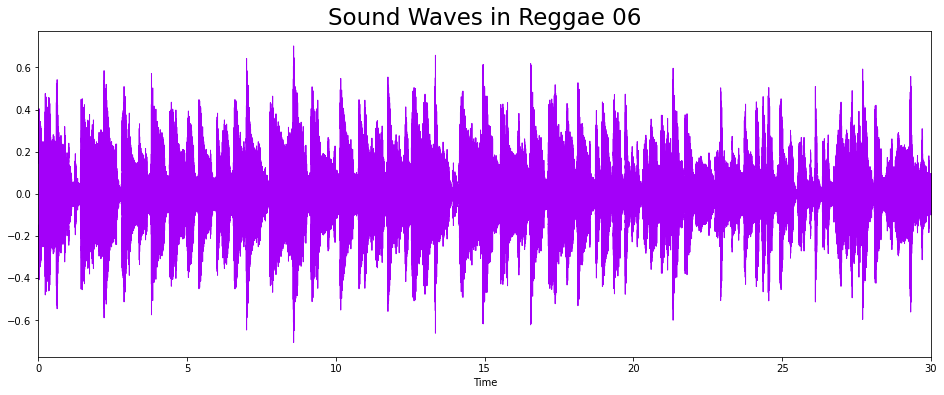

In [ ]:
#@title Visualización de un audio
Example, sr = librosa.load(f'{audio_dataset_path}/reggae/reggae.00006.wav')
audio_file, _ = librosa.effects.trim(Example)
plt.figure(figsize = (16, 6))
librosa.display.waveplot(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Reggae 06", fontsize = 23);

In [ ]:
#@title Dividimos en 40 trozos la canción y separamos frecuencias
#Dividimos en 40 trozos la canción y separamos frecuencias
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast',sr=3000, offset=0.0, duration=5)
    #audio = audio.reshape(1,90001)

    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features, audio

In [ ]:
#@title Lee las canciones
extracted_features=[]
music_names = []
Music = []
for index_num,row in tqdm(metadata.iterrows()):
    try:
        final_class_labels=row["label"]

        file_name = os.path.join(os.path.abspath(audio_dataset_path), final_class_labels+'/',str(row["filename"]))  
        music_names.append(file_name)

        data, audio =features_extractor(file_name)
        extracted_features.append([data,final_class_labels])
        Music.append([audio,final_class_labels])
    except Exception as e:
        clear_output(wait=True)
        print("Error, algo ha salido mal con el archivo, hagamos como que nada pasó")
        continue

556it [02:42,  1.65it/s]

Error, algo ha salido mal con el archivo, hagamos como que nada pasó


1000it [04:44,  3.51it/s]


In [ ]:
#@title converting extracted_features to Pandas dataframe
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-0.9123851, 93.117455, -39.664776, 36.600998,...",blues
1,"[-85.83161, 122.288284, -22.811316, 45.00446, ...",blues
2,"[30.36466, 75.47428, -43.04526, 33.162376, -49...",blues
3,"[-70.893295, 104.738754, -34.86485, 40.041683,...",blues
4,"[-44.16431, 45.59889, -61.21311, 20.307283, -5...",blues


In [ ]:
#@title Cantidad de canciones en cada clase
extracted_features_df['class'].value_counts()

rock         100
pop          100
reggae       100
disco        100
blues        100
hiphop       100
metal        100
country      100
classical    100
jazz          99
Name: class, dtype: int64

<br>

#<h3> **Split the dataset into independent and dependent dataset** 

<br>

In [ ]:
#@title X Shape
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

X.shape

(999, 40)

In [ ]:
#@title y Shape
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

y.shape

(999, 10)


<h2> Train Test Split 

In [ ]:
#@title Separación de datos para train y test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
#@title X train
X_train

array([[ 66.462364  ,  43.292927  , -40.571472  , ...,  -2.3720965 ,
         -2.2206533 ,   2.474626  ],
       [ -6.461635  ,  98.43746   , -15.854954  , ...,  -8.776869  ,
        -12.078034  ,  -6.633683  ],
       [ 25.298025  ,  75.9796    , -15.971072  , ...,  -3.484481  ,
         -5.971685  ,  -4.8090234 ],
       ...,
       [-23.860878  , 123.20443   ,  -1.9222643 , ...,  -3.0104494 ,
         -8.50646   ,   1.1440762 ],
       [-72.529045  ,  63.533344  , -31.66853   , ...,  -1.7755833 ,
         -3.8324864 ,   1.3342099 ],
       [-23.175493  ,  83.28262   , -31.626865  , ...,  -1.6999612 ,
         -4.241721  ,   0.57669634]], dtype=float32)

In [ ]:
#@title Shape de todos las variables
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(799, 40)
(200, 40)
(799, 10)
(200, 10)


In [ ]:
#@title Red Neuronal
num_labels=y.shape[1]
model=Sequential()
model.add(Dense(1024,input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(num_labels, activation="softmax"))

In [ ]:
#@title Summary()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              41984     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [ ]:
#@title Compile
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
#@title Time
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)

In [ ]:
checkpointer = ModelCheckpoint(filepath=f'Proyecto/models/audio_classification_{current_time}.hdf5', verbose=0, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=150, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

Epoch 1/150
25/25 [==============================] - 1s 16ms/step - loss: 4.2787 - accuracy: 0.1202 - val_loss: 2.2852 - val_accuracy: 0.1250
Epoch 2/150
25/25 [==============================] - 0s 9ms/step - loss: 2.5755 - accuracy: 0.1189 - val_loss: 2.2802 - val_accuracy: 0.1400
Epoch 3/150
25/25 [==============================] - 0s 6ms/step - loss: 2.4279 - accuracy: 0.1214 - val_loss: 2.2772 - val_accuracy: 0.1400
Epoch 4/150
25/25 [==============================] - 0s 7ms/step - loss: 2.3254 - accuracy: 0.1264 - val_loss: 2.2509 - val_accuracy: 0.1400
Epoch 5/150
25/25 [==============================] - 0s 7ms/step - loss: 2.3262 - accuracy: 0.1252 - val_loss: 2.2627 - val_accuracy: 0.1550
Epoch 6/150
25/25 [==============================] - 0s 6ms/step - loss: 2.2506 - accuracy: 0.1527 - val_loss: 2.2692 - val_accuracy: 0.1200
Epoch 7/150
25/25 [==============================] - 0s 6ms/step - loss: 2.2547 - accuracy: 0.1552 - val_loss: 2.2409 - val_accuracy: 0.1550
Epoch 8/150


In [ ]:
#@title Evaluate
model.evaluate(X_test,y_test,verbose=0)

[2.7273294925689697, 0.4449999928474426]

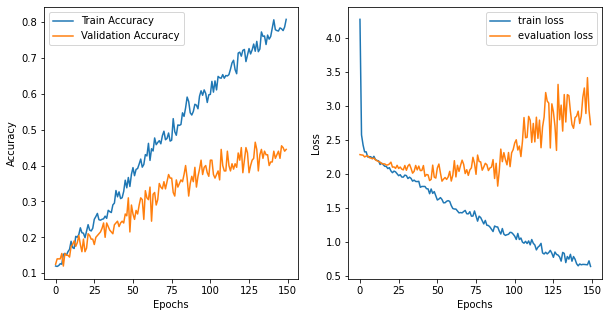

In [ ]:
#@title Gráfica Red creada
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [ ]:
#@title Prueba
prueba = 120 #@param {type:"slider", min:0, max:997, step:1}
music_names[prueba]
audio, sample_rate = librosa.load(music_names[prueba], res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

#print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
predicted_label = np.argmax(predicted_label, axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
print(prediction_class)
print(music_names[prueba])

(1, 40)
[7]
['pop']
/content/drive/MyDrive/Proyecto/Data/genres_original/classical/classical.00020.wav


<br><br>
<h1> Another way to do it (Transfer leraning)

In [ ]:
#@title Constantes
IMAGE_WIDTH = 336
IMAGE_HEIGHT = 218
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


path_img='/content/drive/MyDrive/Proyecto/Data2/images_original/'

categories= {0: 'blues', 1: 'classical', 2: 'country',
          3: 'disco', 4: 'hiphop',5: 'jazz', 6: 'metal',
          7: 'pop', 8: 'reggae', 9: 'rock'}

In [ ]:
print(os.getcwd())

/content/drive/MyDrive


In [ ]:
#@title Creación del dataframe
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(path_img + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  999


In [ ]:
#@title  Muestra del DF creado
df.head()

,filename,category
0,hiphop/hiphop00032.png,4
1,classical/classical00072.png,1
2,classical/classical00082.png,1
3,classical/classical00064.png,1
4,disco/disco00000.png,3


reggae/reggae00057.png


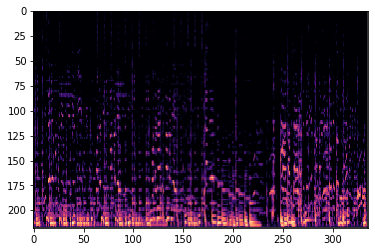

In [ ]:
#@title Visualización de una imagen aleatoria
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(path_img +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

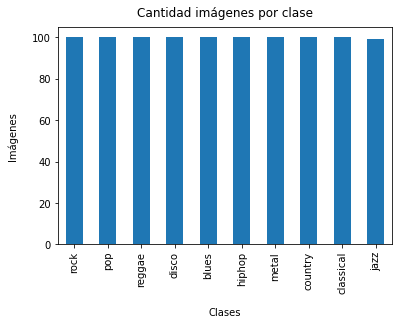

In [ ]:
#@title Gráfica del dataframe
df_visualization = df.copy()

df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )
df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Clases", labelpad=14)
plt.ylabel("Imágenes", labelpad=14)
plt.title("Cantidad imágenes por clase", y=1.02);

In [ ]:
#@title Se divide el DF para entrenamiento y testeo
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
X2, y2 = train_test_split(df, test_size=0.2, random_state=42)


X2 = X2.reset_index(drop=True)
y2 = y2.reset_index(drop=True)

print('train = ', X2.shape[0] , 'test = ', y2.shape[0])

train =  799 test =  200


In [ ]:
#@title train generator
batch_size=64

train_datagen = image.ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    X2, 
    path_img, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 799 validated image filenames belonging to 10 classes.


In [ ]:
#@title test generator
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    y2, 
    path_img, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 200 validated image filenames belonging to 10 classes.


In [ ]:
#@title Red Xception
model_TL = tf.keras.applications.Xception(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), weights='imagenet', include_top=False)
model_TL.trainable = False
model_TL.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 336, 218, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 167, 108, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 167, 108, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 167, 108, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [ ]:
#@title create some layers to add 
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
flatten_layer = tf.keras.layers.Flatten()
Dense_layer1 = tf.keras.layers.Dense(256, activation='relu')
Dense_layer2 = tf.keras.layers.Dense(128, activation='relu')
Dense_layer3 = tf.keras.layers.Dense(64, activation='relu')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
#@title adapt the pre-trained model in a new model

model_B_on_TL = tf.keras.Sequential([
  model_TL,
  flatten_layer,
  Dense_layer1,
  Dense_layer2,
  Dense_layer3,
  prediction_layer
])

In [ ]:
#@title Summary
model_B_on_TL.summary()
print("number of layers to train: ", len(model_B_on_TL.trainable_variables))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 11, 7, 2048)       20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 157696)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               40370432  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 61,273,714
Trainable params: 40,412,234
Non-trainable params: 20,861,480
_________________________________

In [ ]:
#@title Compile
opt = tf.keras.optimizers.Adam()
model_B_on_TL.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#@title Fit

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)

checkpointer2 = ModelCheckpoint(filepath=f'Proyecto/models/modelo_transferido_{current_time}.hdf5', verbose=0, save_best_only=True)

history_TL = model_B_on_TL.fit(train_generator, epochs=10, verbose=2, validation_data=test_generator, callbacks=[checkpointer2])


Epoch 1/10
13/13 - 165s - loss: 71.9693 - accuracy: 0.1840 - val_loss: 37.6056 - val_accuracy: 0.1950


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
13/13 - 15s - loss: 17.7723 - accuracy: 0.3191 - val_loss: 18.3786 - val_accuracy: 0.3000
Epoch 3/10
13/13 - 15s - loss: 8.1332 - accuracy: 0.5407 - val_loss: 16.3231 - val_accuracy: 0.3700
Epoch 4/10
13/13 - 15s - loss: 3.6441 - accuracy: 0.6646 - val_loss: 11.4931 - val_accuracy: 0.3900
Epoch 5/10
13/13 - 15s - loss: 1.6440 - accuracy: 0.7685 - val_loss: 12.8003 - val_accuracy: 0.3500
Epoch 6/10
13/13 - 15s - loss: 1.0764 - accuracy: 0.8348 - val_loss: 11.1830 - val_accuracy: 0.3950
Epoch 7/10
13/13 - 15s - loss: 0.5479 - accuracy: 0.8986 - val_loss: 9.6839 - val_accuracy: 0.4450
Epoch 8/10
13/13 - 15s - loss: 0.3137 - accuracy: 0.9374 - val_loss: 8.4477 - val_accuracy: 0.4200
Epoch 9/10
13/13 - 15s - loss: 0.1076 - accuracy: 0.9700 - val_loss: 10.0758 - val_accuracy: 0.4500
Epoch 10/10
13/13 - 15s - loss: 0.1560 - accuracy: 0.9762 - val_loss: 9.5782 - val_accuracy: 0.4400


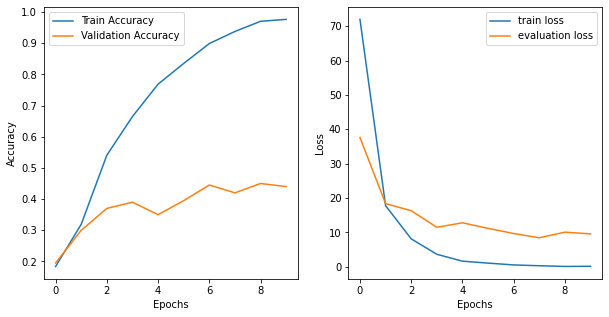

In [ ]:
#@title Gráfica Xception
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history_TL.history['accuracy'], label='Train Accuracy');
ax.plot(history_TL.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history_TL.history['loss'], label='train loss');
ax.plot(history_TL.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

<br><br>

<h2>InceptionMobileNet

In [ ]:
#@title MobileNet
model_TL2 = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), weights='imagenet', include_top=False)
model_TL2.trainable = False
model_TL2.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 336, 218, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 168, 109, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 168, 109, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 168, 109, 32) 0           bn_Conv1[0][0]                   
________________

In [ ]:
#@title create some layers to add 
prediction_layer2 = tf.keras.layers.Dense(10, activation='softmax')
flatten_layer2 = tf.keras.layers.Flatten()
Dense_layer22 = tf.keras.layers.Dense(128, activation='relu')
Dense_layer32 = tf.keras.layers.Dense(64, activation='relu')
global_average_layer2 = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
#@title adapt the pre-trained model in a new model

model_B_on_TL2 = tf.keras.Sequential([
  model_TL2,
  global_average_layer2,
  Dense_layer22,
  Dense_layer32,
  prediction_layer2
])

In [ ]:
#@title Summary
model_B_on_TL2.summary()
print("number of layers to train: ", len(model_B_on_TL2.trainable_variables))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 11, 7, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
Total params: 2,430,858
Trainable params: 172,874
Non-trainable params: 2,257,984
_________________________________________________________________
number of layers to train:  6


In [ ]:
#@title Fit
model_B_on_TL2.compile(optimizer=Adam(learning_rate=0.00025), loss='categorical_crossentropy',metrics=['accuracy'])
history_TL2 = model_B_on_TL2.fit(train_generator, epochs=16, verbose=2, validation_data=test_generator)


Epoch 1/16
13/13 - 13s - loss: 2.3141 - accuracy: 0.1239 - val_loss: 2.1423 - val_accuracy: 0.2250
Epoch 2/16
13/13 - 5s - loss: 2.0274 - accuracy: 0.2941 - val_loss: 1.9343 - val_accuracy: 0.2900
Epoch 3/16
13/13 - 5s - loss: 1.8328 - accuracy: 0.3692 - val_loss: 1.7517 - val_accuracy: 0.3800
Epoch 4/16
13/13 - 5s - loss: 1.6864 - accuracy: 0.4143 - val_loss: 1.6344 - val_accuracy: 0.4100
Epoch 5/16
13/13 - 5s - loss: 1.5736 - accuracy: 0.4643 - val_loss: 1.5626 - val_accuracy: 0.4250
Epoch 6/16
13/13 - 5s - loss: 1.4815 - accuracy: 0.4994 - val_loss: 1.4716 - val_accuracy: 0.5100
Epoch 7/16
13/13 - 5s - loss: 1.4266 - accuracy: 0.5257 - val_loss: 1.4495 - val_accuracy: 0.4800
Epoch 8/16
13/13 - 5s - loss: 1.3556 - accuracy: 0.5507 - val_loss: 1.3799 - val_accuracy: 0.5200
Epoch 9/16
13/13 - 5s - loss: 1.3093 - accuracy: 0.5632 - val_loss: 1.3665 - val_accuracy: 0.5100
Epoch 10/16
13/13 - 5s - loss: 1.2555 - accuracy: 0.5932 - val_loss: 1.3121 - val_accuracy: 0.5450
Epoch 11/16
13/13 

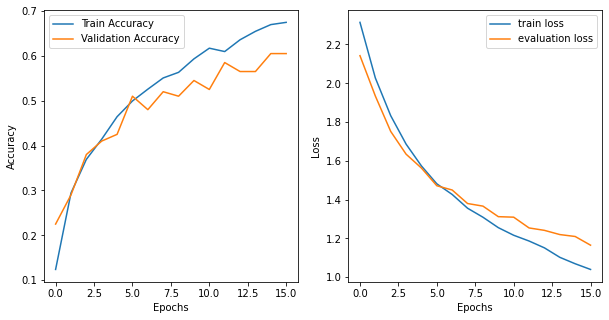

In [ ]:
#@title Gráfica Mobile
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history_TL2.history['accuracy'], label='Train Accuracy');
ax.plot(history_TL2.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history_TL2.history['loss'], label='train loss');
ax.plot(history_TL2.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');


<br><br>

<h2> Autoencoders


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
BATCH_SIZE = 8
epochs = 20

latent_dim = 2
num_examples_to_generate = 2
os.chdir('/content/drive/My Drive/Proyecto')
BASE_PATH = 'Data/genres_original'

In [ ]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[[0,52,19,39,71,12,75,85,3,45,24,46,88]]) 
    train_music_2 = list(music_list[[4,43,56,55,45,31,11,13,70,37,21,78]]) 
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

In [ ]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    data_ = data_.reshape(1,90001)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [ ]:
TrackSet_1, TrackSet_2 = DatasetLoader('jazz')

In [ ]:
sample = TrackSet_1[12]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=30)
ipd.Audio(sample_,rate=3000)

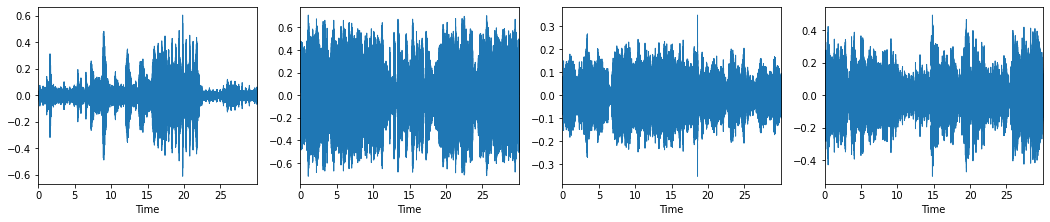

In [ ]:
import librosa.display
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    librosa.display.waveplot(j[0], sr=3000)

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [ ]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__(name='')
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

In [ ]:
class CVAE(tf.keras.Model):

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,90001)),
                layers.Conv1D(64,1,2),
                Resnet1DBlock(64,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                Resnet1DBlock(256,1),
                
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                Resnet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                Resnet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                Resnet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                
                layers.Conv1DTranspose(90001,1,1),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
        
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [ ]:
model = CVAE(latent_dim)

In [ ]:
import librosa.display
save_music=[]
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        if epoch==20:
            save_music.append(wave)
        librosa.display.waveplot(wave[0], sr=3000)

In [ ]:
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

In [ ]:
@tf.function
def train_step(model, x, optimizer):
    
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss + loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [ ]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

Epoch: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


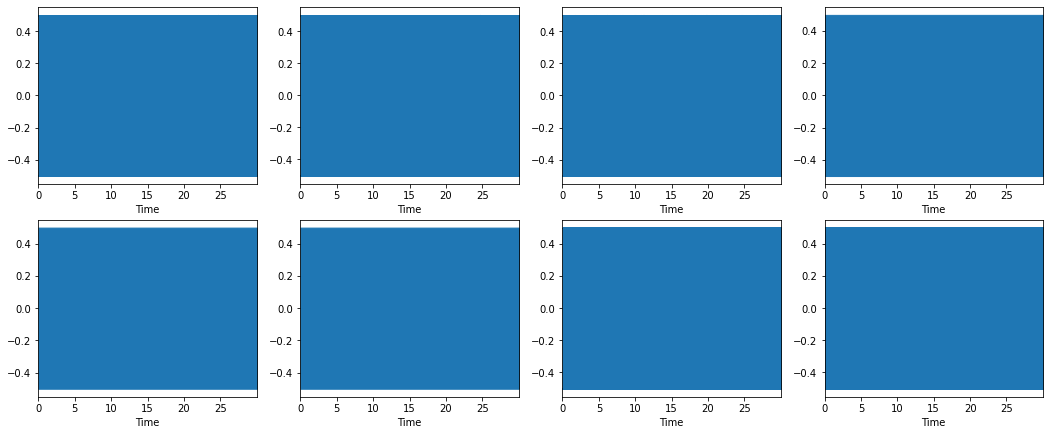

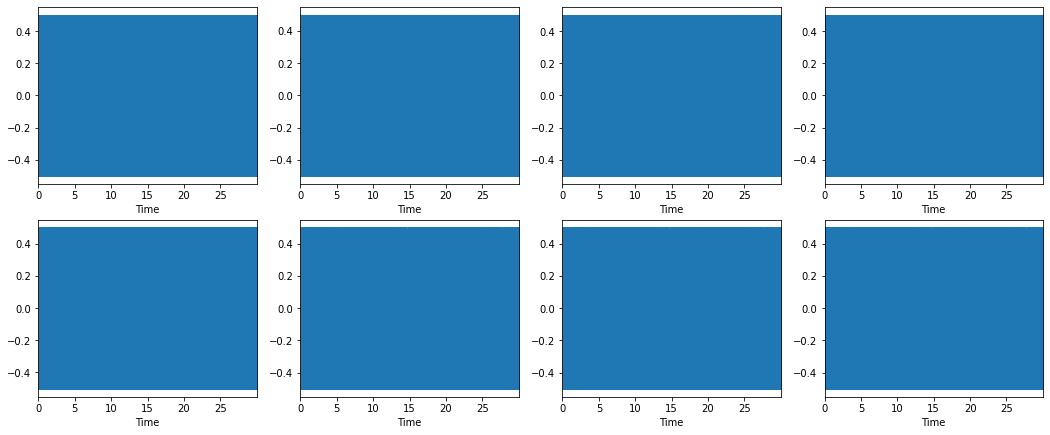

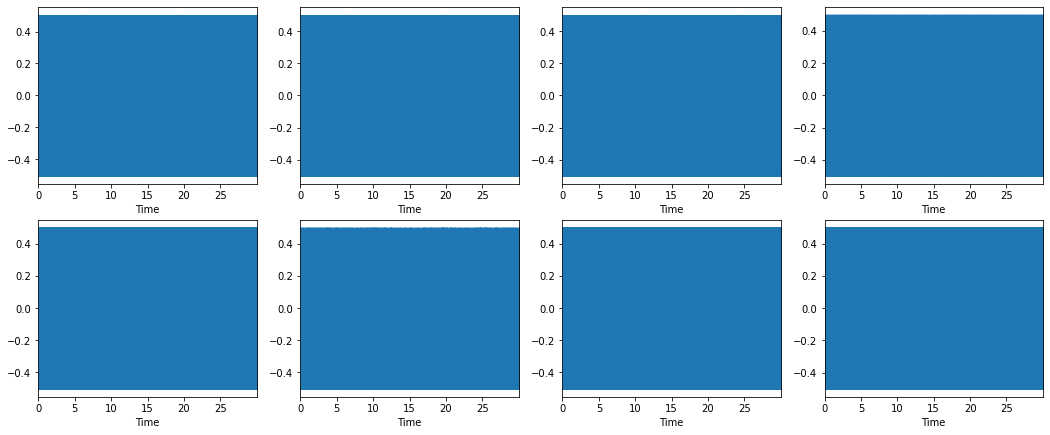

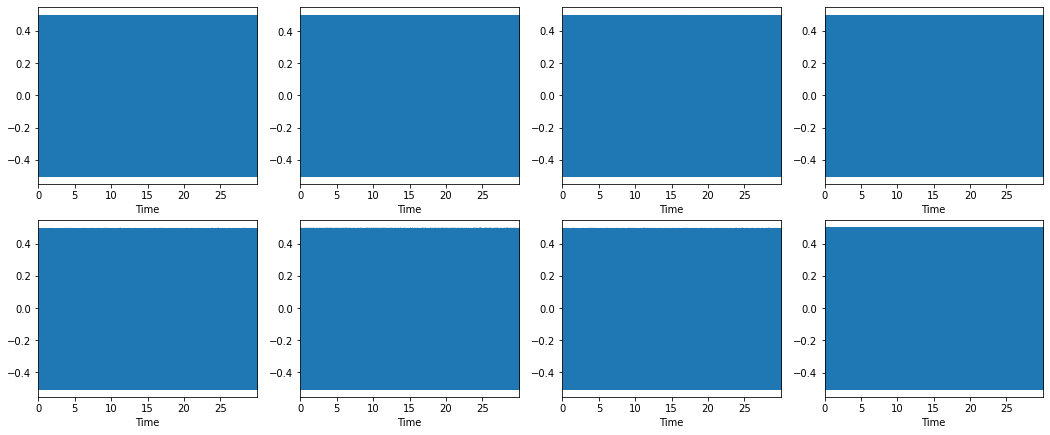

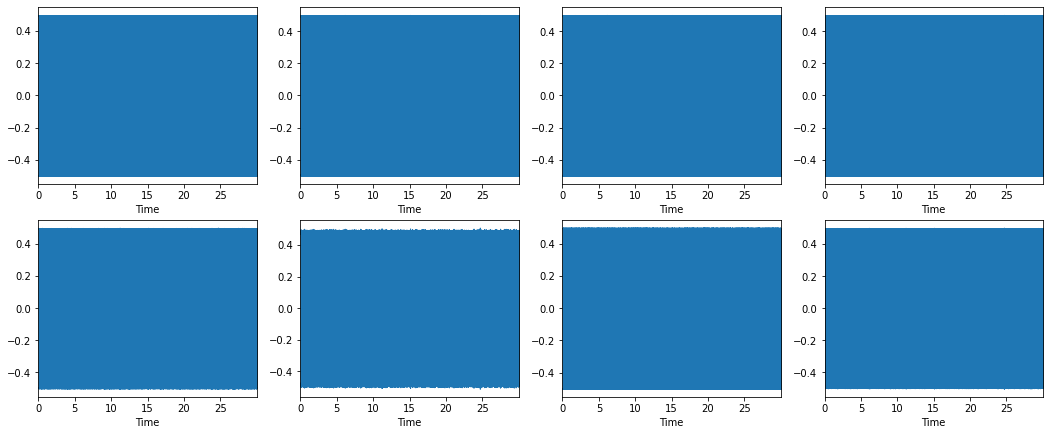

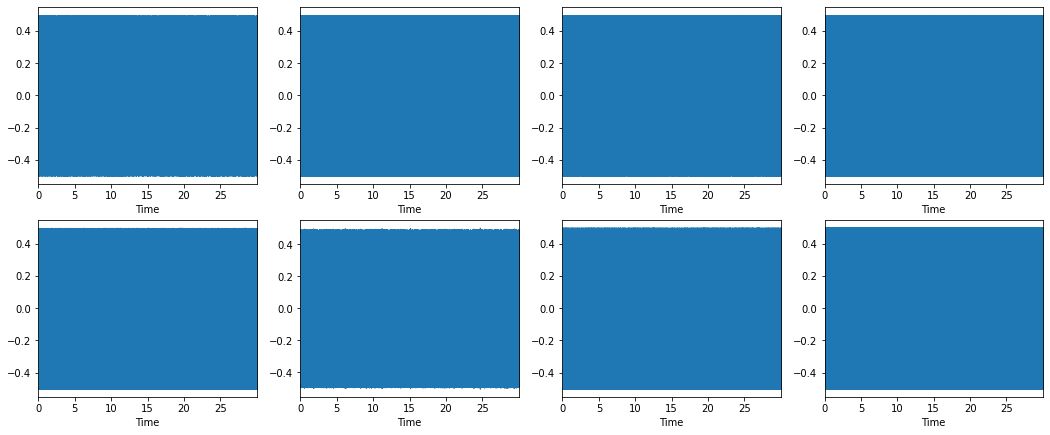

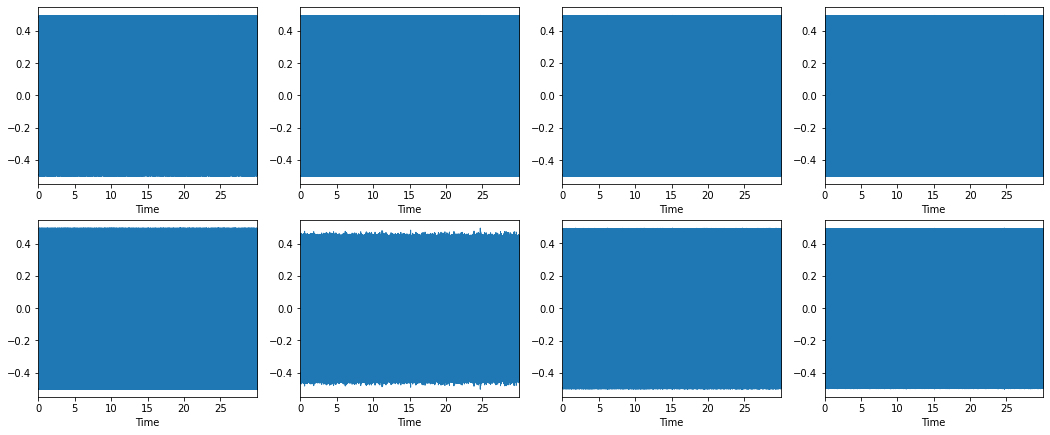

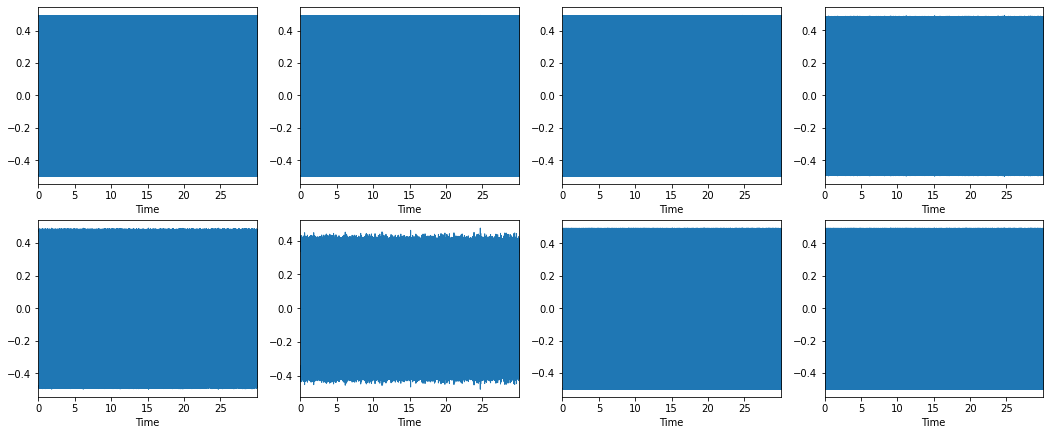

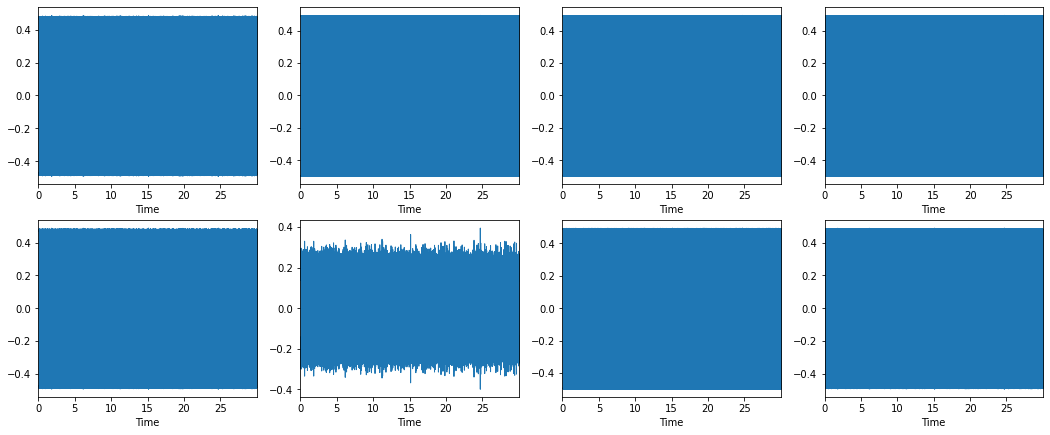

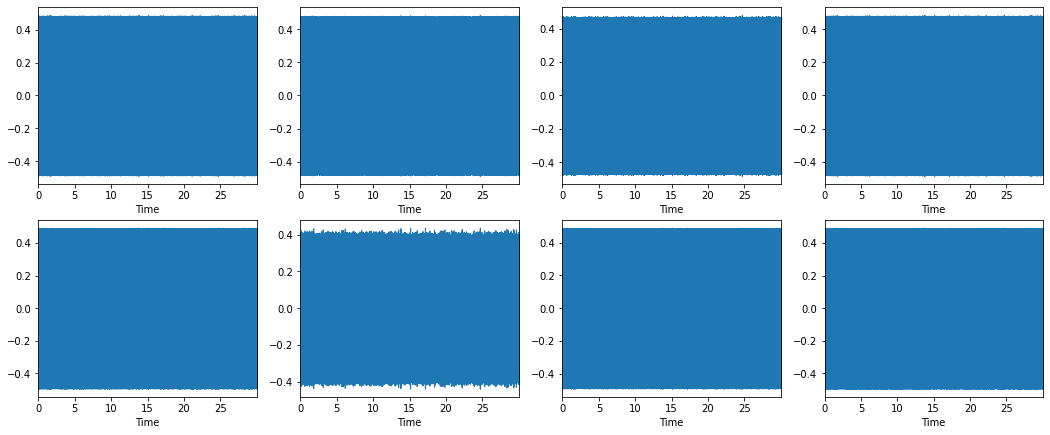

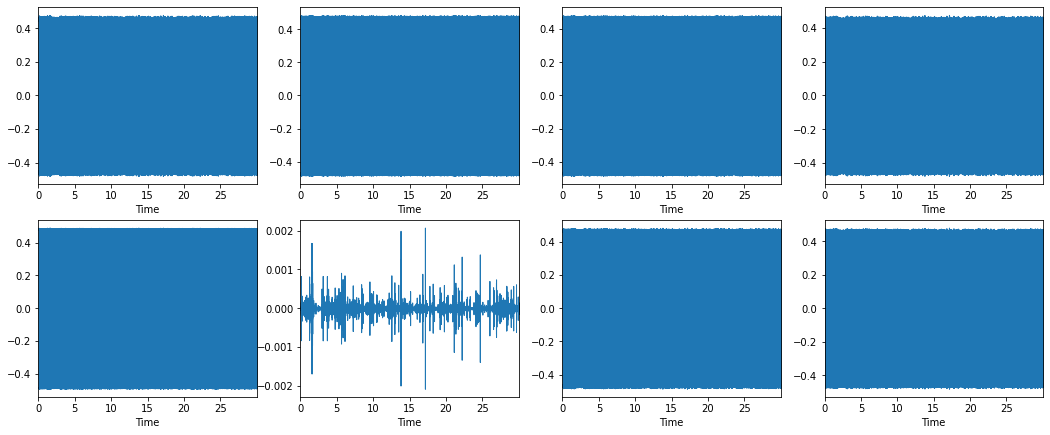

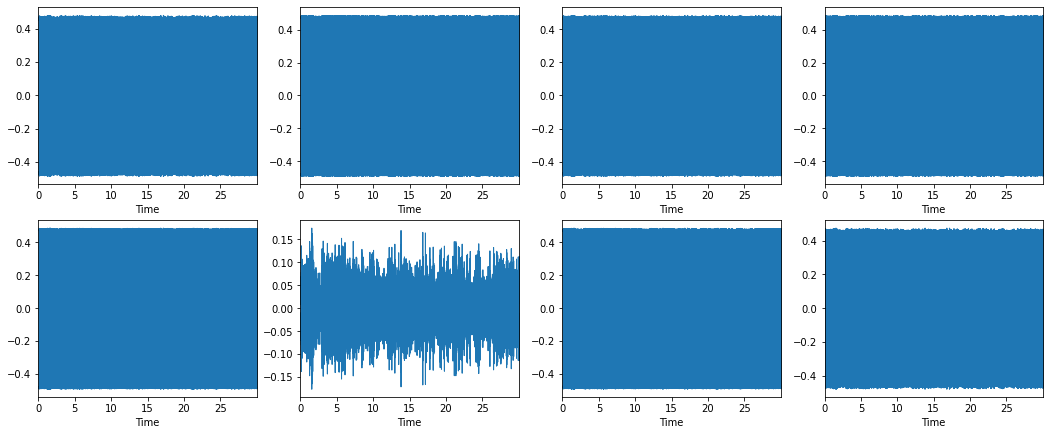

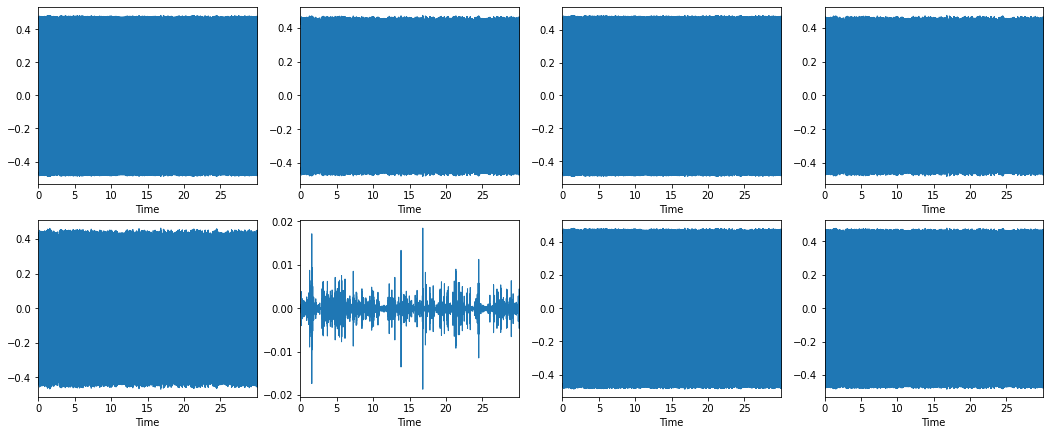

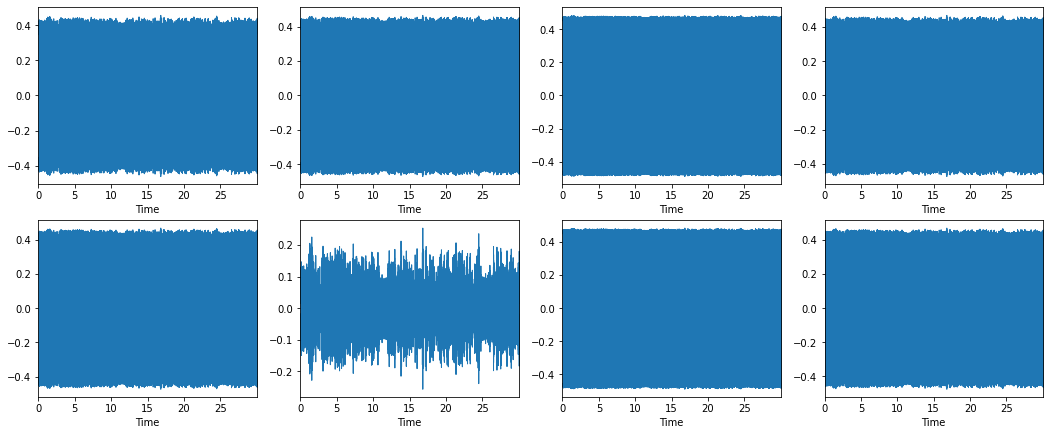

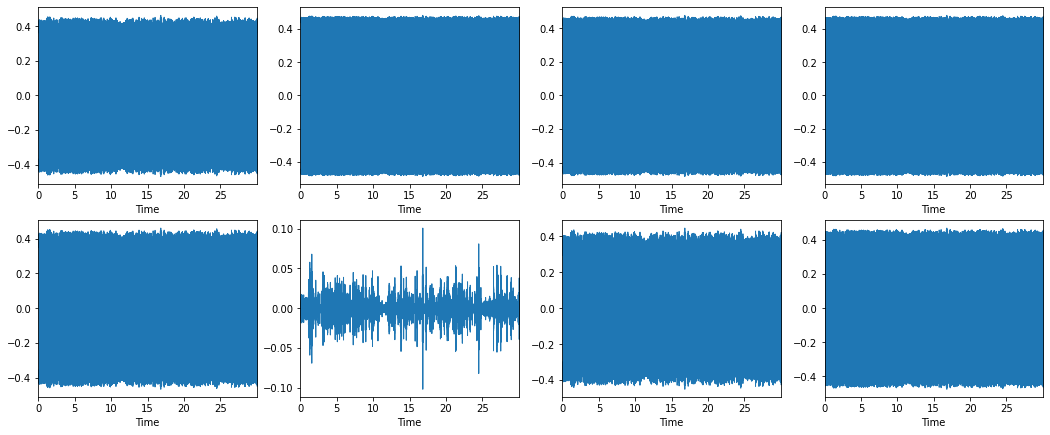

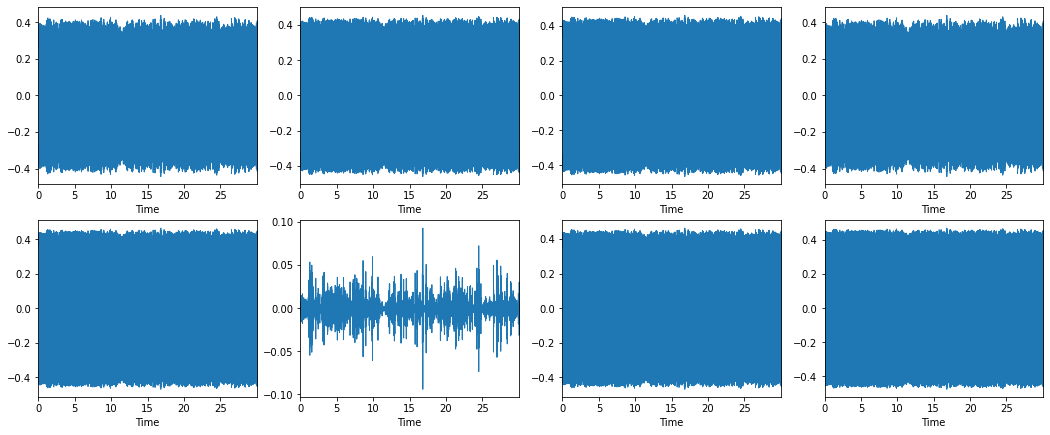

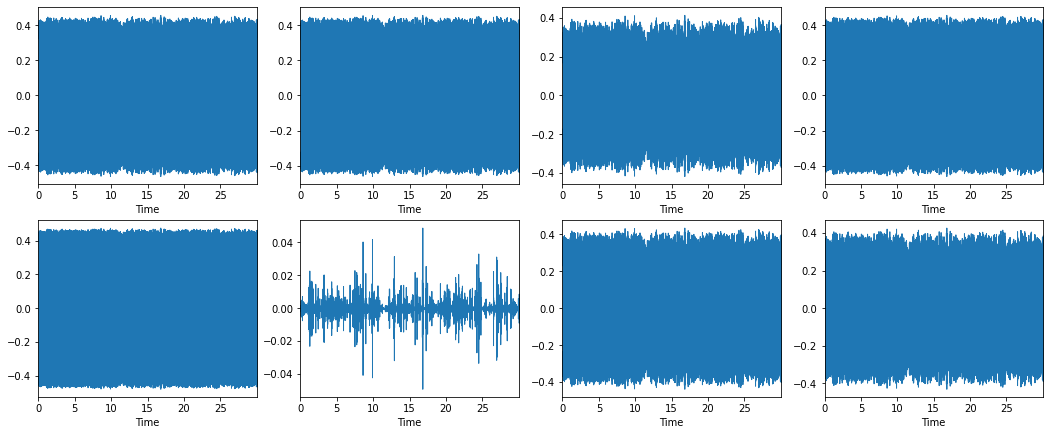

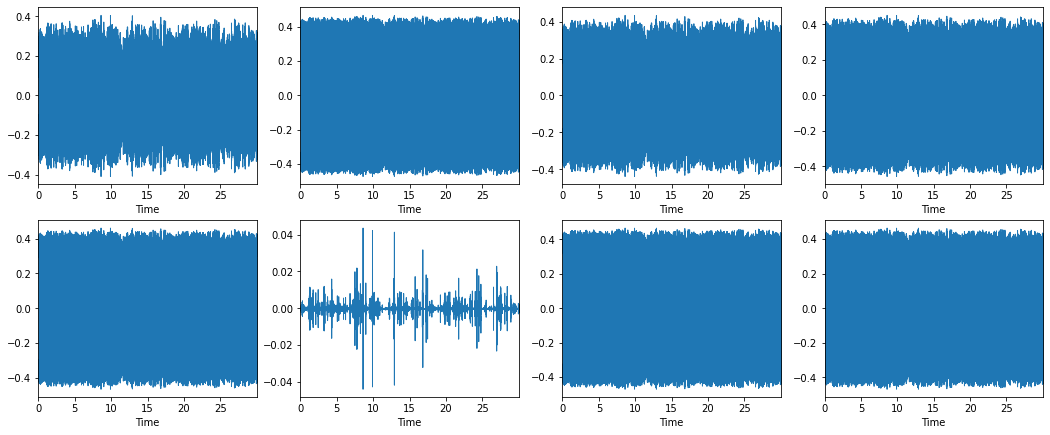

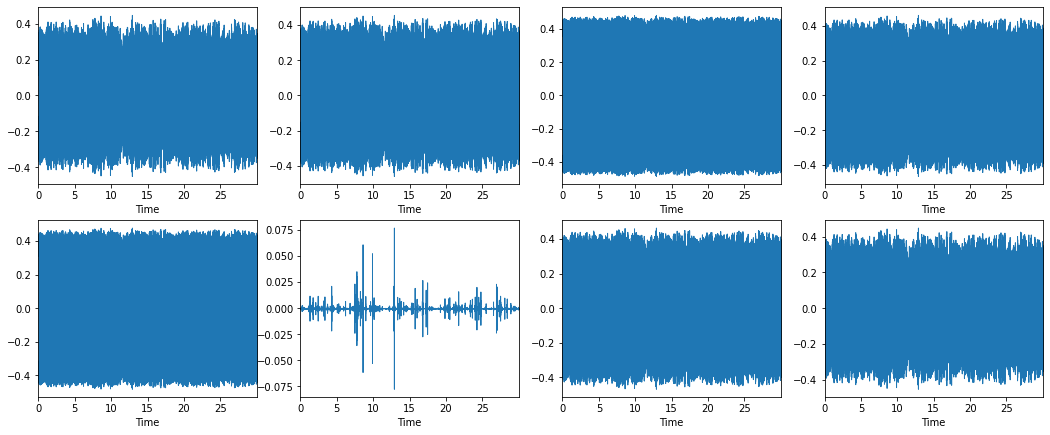

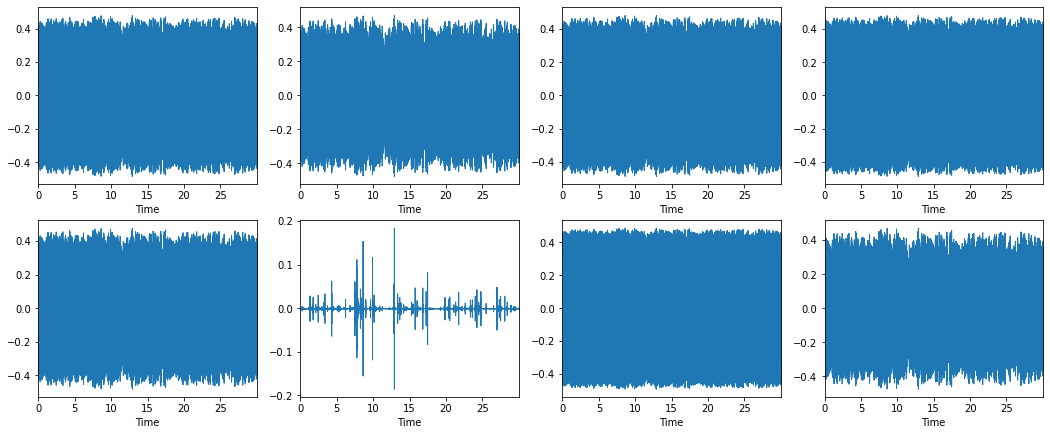

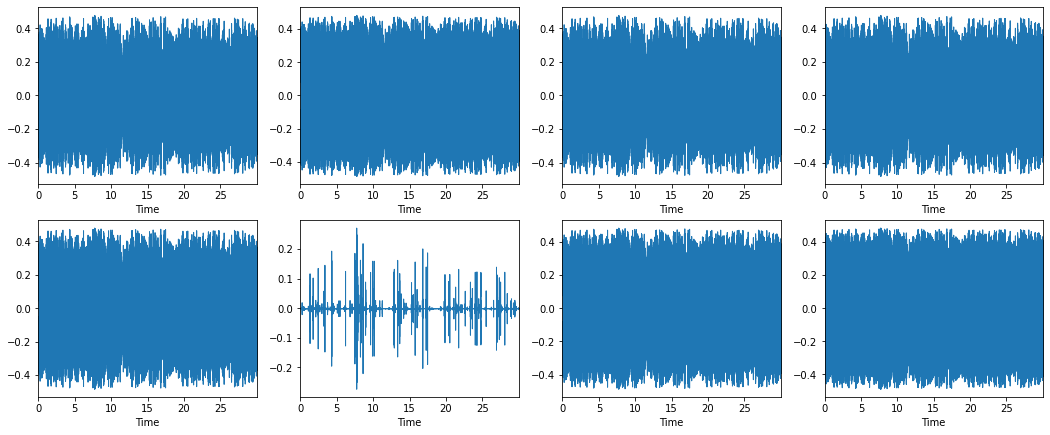

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  
    for train_x in train_dataset:
        train_x = np.asarray(train_x)[0]
        train_step(model, train_x, optimizer)
    
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        test_x = np.asarray(test_x)[0]
        loss(compute_loss(model, test_x))
    clear_output(wait=False)
    elbo = -loss.result()
    print('Epoch: '+ str(epoch))
    generate_and_save_images(model, epoch, test_sample)

In [ ]:
l1=save_music[7][0]
ipd.Audio(l1,rate=3000)

In [ ]:
l1 = TrackSet_1[7]
ipd.Audio(l1,rate=3000)

In [ ]:
save_music[1].shape

(1, 90001)

<br><br>

<h2>Autoencoder Aplicado en Coeﬁcientes Cepstrales en las Frecuencias de Mel

In [ ]:
#@title Preprocesamiento
max1 = 0
min1 = 0
for i in X:
  if max1 < i.max():
    max1 = i.max()
  if min1 > i.min():
    min1 = i.min()
print('max: '+str(max1)+ ' min: '+ str(min1))
print(max1-min1)
max1 = 0
min1 = 1000
X3 = X + 552.12006
X3 = ((X3*2)/745.21747)-1
for i in X3:
  if max1 < i.max():
    max1 = i.max()
  if min1 > i.min():
    min1 = i.min()
print('max: '+str(max1)+ ' min: '+ str(min1))
print(max1-min1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X3,y,test_size=0.8,random_state=0)

In [ ]:
input_img = tf.keras.layers.Input(shape=(X_train.shape[1],))
#encoded = tf.keras.layers.Dense(35, activation='tanh')()
#encoded = tf.keras.layers.BatchNormalization()(encoded)
encoded = tf.keras.layers.Dense(20, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(10, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(20, activation='relu')(encoded) #Aumento
#decoded = tf.keras.layers.Dropout(0.2)(decoded) 
#decoded = tf.keras.layers.Dense(35, activation='relu')(decoded) 
decoded = tf.keras.layers.Dense(40, activation='relu')(decoded)#40
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.summary()

In [ ]:
opt = tf.optimizers.Adam()
autoencoder.compile(optimizer=opt, metrics='accuracy', loss='binary_crossentropy')
Historyauto = autoencoder.fit(X_train, X_train, epochs=100,
                validation_data=(X_test, X_test))

In [ ]:
#@title **code** predict and visualize over fashion
# Encoder
encoder = tf.keras.models.Model(input_img, encoded)
encoded_imgs = encoder.predict(X_test)
predicted = autoencoder.predict(X_test)

In [ ]:
plt.plot(predicted[1])

In [ ]:

plt.figure(figsize=(40, 4))
for i in range(10):
    # display original

    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_test[i].reshape(4,10), cmap='summer')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(2,5), cmap='autumn')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction

    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(4,10), cmap='summer')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)